In [1]:
import pandas as pd
from gensim.models import Word2Vec
import gensim
from nltk.corpus import stopwords
import re
import nltk
from gensim.parsing.preprocessing import remove_stopwords
import numpy as np
from nltk.stem import WordNetLemmatizer
import numpy as np
import pickle as pkl
import torch
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
import torch.nn as nn
import math
from torch.utils.data import DataLoader, TensorDataset

In [2]:
model = Word2Vec.load("./word2vec.model")

In [3]:
df = pd.read_csv("./Tweets_SG_HK_Aus/HKTweetsHydrated.csv",  engine='python')

In [4]:
print(df.columns)

Index(['tweet_id', 'user_id', 'tweet_timestamp', 'keyword', 'country/region',
       'valence_intensity', 'fear_intensity', 'anger_intensity',
       'happiness_intensity', 'sadness_intensity', 'sentiment', 'emotion',
       'text'],
      dtype='object')


In [5]:
df = df.dropna()

In [6]:
df.drop(df.loc[df['sentiment']=='neutral or mixed'].index, inplace=True)

In [7]:
df["sentiment"] = df['sentiment'].replace(['very positive'], 'positive')

In [8]:
df["sentiment"] = df['sentiment'].replace(['very negative'], 'negative')

In [9]:
df['sentiment'].value_counts()

negative    70685
positive    32474
Name: sentiment, dtype: int64

In [10]:
df_new = df[df['sentiment'] == 'negative'].sample(32474)
df_new = df_new.append(df[df['sentiment'] == 'positive'].sample(32474))
#df_new = df_new.append(df[df['sentiment']=='neutral or mixed'])
df = df_new

In [11]:
text_corpus = df['text'].apply(str)

In [ ]:
val = []
for i in text_corpus:
    text = i
    text = re.sub(r'http\S+' , ' ' , text)
    text = re.sub('@\w+' , ' ' , text)
    text = re.sub('#' , ' ' , text)
    text = re.sub('RT' , ' ' , text)
    text = re.sub('&amp;' , ' ' , text)
    text = re.sub('&quot;' , ' ' , text)
    text = re.sub('&gt' , ' ' , text)
    text = re.sub('&lt' , ' ' , text)
    val.append(text)

In [12]:
val = []
for i in text_corpus:
    text = i
    text = re.sub(r'\[[0-9]*\]' , ' ' , text)
    text = re.sub(r'\s+' , ' ' , text)
    text = text.lower()
    text = re.sub(r'\d' , ' ' , text)
    text = re.sub(r'\s+' , ' ' , text)
    val.append(text)

In [13]:
sentences = [nltk.word_tokenize(st) for st in val]

In [14]:
count  = len(sentences)
stop_words = set(stopwords.words("english"))
for i in range(0 , count):
    sentences[i] = [word for word in sentences[i] if word not in stop_words]

In [15]:
lemmatizer = WordNetLemmatizer()
maxLen = 0
for i in range(count):
    if len(sentences[i])>maxLen:
        maxLen = len(sentences[i])
    for j in range(len(sentences[i])):
        sentences[i][j] = lemmatizer.lemmatize(sentences[i][j])

In [16]:
maxLen

86

In [17]:
import numpy as np
val = np.zeros((count , maxLen, 100))

for sentence , j in zip(sentences , range(0 , count)):
    arr = np.zeros((maxLen,100))
    i = 0
    for word in sentence:
            if word in model.wv:
                arr[i] = model.wv[word]
            else:
                arr[i] = model.wv['unknown']
            i+=1
    val[j] = arr 
    if j%10000 == 0 and j!=0:
        print(f"Preprocessed {j}")

Preprocessed 10000
Preprocessed 20000
Preprocessed 30000
Preprocessed 40000
Preprocessed 50000
Preprocessed 60000


In [18]:
X = val
y = df["sentiment"]

In [19]:
def label_map(label):
    if label == "negative":
        return 0
    elif label == "positive":
        return 1

In [20]:
y = y.apply(label_map)

In [21]:
device= torch.device("cuda")
#device= torch.device("cpu")
print(device)

cuda


In [22]:


embedding_dim = 100
hidden_dim = 300
output_dim = 3
dropout_rate = 0.5
bidirectional = True


In [23]:
class BiLSTM_SentimentAnalysis(torch.nn.Module) :
    def __init__(self, embedding_dim, hidden_dim, dropout) :
        super().__init__()


        # The LSTM layer takes in the the embedding size and the hidden vector size.
        # The hidden dimension is up to you to decide, but common values are 32, 64, 128
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)

        # We use dropout before the final layer to improve with regularization
        self.dropout = nn.Dropout(dropout)

        # The fully-connected layer takes in the hidden dim of the LSTM and
        #  outputs a a 3x1 vector of the class scores.
        self.fc = nn.Linear(hidden_dim, 3)

    def forward(self, x, h_init, c_init):
        """
        The forward method takes in the input and the previous hidden state 
        """

        # The input is transformed to embeddings by passing it to the embedding layer
        # embs = self.embedding(x)

        # The embedded inputs are fed to the LSTM alongside the previous hidden state
        out, (h_final, c_final) = self.lstm(x.float(), (h_init, c_init))

        # Dropout is applied to the output and fed to the FC layer
        out = self.dropout(out)
        out = self.fc(out)

        # We extract the scores for the final hidden state since it is the one that matters.
        out = out[:, -1]
        return out, h_final, c_final
    
    def init_hidden(self):
        return (torch.zeros(1, batch_size, 32), torch.zeros(1, batch_size, 32))

In [24]:
model = BiLSTM_SentimentAnalysis( embedding_dim, 300, 0.3)
model = model.to(device)

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 3e-4)

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.20, random_state=10)


batch_size = 64

train_ds = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train.to_numpy()))
test_ds = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test.to_numpy()))


train_dl = DataLoader(train_ds, shuffle=True, batch_size=batch_size, drop_last=True)
test_dl = DataLoader(test_ds, shuffle=True, batch_size=batch_size, drop_last=True)

In [27]:
epochs = 10
losses = []
for e in range(epochs):

    h0 = torch.zeros(1, batch_size, hidden_dim)
    c0 = torch.zeros(1, batch_size, hidden_dim)
   
    h0=h0.to(device)
    c0=c0.to(device)

    for batch_idx, batch in enumerate(train_dl):

        input = batch[0].to(device)
        target = batch[1].to(device)

        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            out, h, c = model(input, h0, c0)
            loss = criterion(out, target)
            loss.backward()
            optimizer.step()
    losses.append(loss.item())

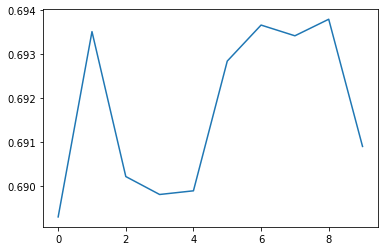

In [28]:
import matplotlib.pyplot as plt
plt.plot(losses)

In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report

batch_acc = []
batch_prec = []
batch_f1 = []
batch_rec = []
pred = []
targets = []
for batch_idx, batch in enumerate(test_dl):

    input = batch[0].to(device)
    target = batch[1].to(device)

    optimizer.zero_grad()
    with torch.set_grad_enabled(False):
        out, h, c = model(input, h0, c0)
        _, preds = torch.max(out, 1)
        preds = preds.to("cpu").tolist()
        pred.extend(preds)
        targets.extend(target.tolist())
        batch_f1.append(f1_score(preds, target.tolist() , average=None))
        batch_acc.append(accuracy_score(preds, target.tolist()))
        batch_prec.append(precision_score(preds, target.tolist(), average=None))
        batch_rec.append(recall_score(preds, target.tolist(), average=None))
print(f"f1 score : {sum(batch_f1)/len(batch_f1)}")
print(f"accuracy score : {sum(batch_acc)/len(batch_acc)}")
print(f"precison score : {sum(batch_prec)/len(batch_prec)}")
print(f"recall score : {sum(batch_rec)/len(batch_rec)}")
print(f"classification report : {classification_report(pred,targets)}")

f1 score : [0.48587326 0.50622231]
accuracy score : 0.5
precison score : [0.48428935 0.51682116]
recall score : [0.49662004 0.50415213]
classification report :               precision    recall  f1-score   support

           0       0.48      0.50      0.49      6247
           1       0.52      0.50      0.51      6681

    accuracy                           0.50     12928
   macro avg       0.50      0.50      0.50     12928
weighted avg       0.50      0.50      0.50     12928

